In [ ]:
# ==============================================================
# 0.  IMPORTS, CONSTANTES, INTERFACES BÁSICAS
# ==============================================================

from pathlib import Path
from abc import ABC, abstractmethod
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt  # por si lo necesitas al final

# --------------------  Sampleable ------------------------------


class Sampleable(ABC):
    @property
    @abstractmethod
    def dim(self) -> int: ...
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor: ...


# ==============================================================
# 1.  DATASET  (u , x , t)  —  actúa como Dataset **y** Sampleable
# ==============================================================


class WaveTensorDataset(Sampleable, torch.utils.data.Dataset):
    """
    Cada ítem       = [u , x , t]   (float32)
    Conditioning z  =  u*  (el valor de referencia)
    """

    _dim = 1  # la variable que aprenderemos es u

    def __init__(self, pt_file: Path, device: torch.device = DEVICE):
        d = torch.load(pt_file, map_location=device)
        xx, tt = torch.meshgrid(d["x"], d["t"], indexing="ij")
        z = d["u"].T.reshape(-1, 1).float()  # u*
        self.z = z  # (N,1)
        self.data = z  # Alias      (N,1)

    # Dataset API
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        return self.data[i]

    # Sampleable API
    @property
    def dim(self):
        return self._dim

    def sample(self, n):  # muestrea z ~ p_data
        idx = torch.randint(0, len(self), (n,), device=self.data.device)
        return self.data[idx]


# ==============================================================
# 2.  SCHEDULES  α(t)=t   ,   β(t)=√(1-t)
# ==============================================================


class LinearAlpha:
    def __call__(self, t):
        return t

    def dt(self, t):
        return torch.ones_like(t)


class SquareRootBeta:
    def __call__(self, t):
        return torch.sqrt(1.0 - t)

    def dt(self, t):
        return -0.5 / (torch.sqrt(1.0 - t) + 1e-8)


alpha, beta = LinearAlpha(), SquareRootBeta()

# ==============================================================
# 3.  COND. PROBABILITY PATH  p_t(u | u*)
# ==============================================================


class ConditionalProbabilityPath(ABC, nn.Module):
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple, self.p_data = p_simple, p_data

    # --- API que cada problema debe implementar ---
    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor: ...
    @abstractmethod
    def sample_conditional_path(
        self, z: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor: ...
    @abstractmethod
    def conditional_vector_field(
        self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor: ...


# -----------  Implementación para el problema de ondas ----------


class WaveConditionalPath(ConditionalProbabilityPath):
    """
    z  = u*               (valor real)
    x  = u_t              (valor perturbado)
    p_simple = N(0,1)     (ruido ε)
    """

    def __init__(self, p_data: Sampleable):
        super().__init__(p_simple=None, p_data=p_data)

    # z ~ p_data
    def sample_conditioning_variable(self, n):
        return self.p_data.sample(n)

    # x = α(t) z + β(t) ε
    def sample_conditional_path(self, z, t):
        eps = torch.randn_like(z)
        return alpha(t) * z + beta(t) * eps

    # u_t(x|z) = A(t) z + B(t) x   con
    # A(t)=α'(t) - β'(t)/β(t) α(t)   ,   B(t)=β'(t)/β(t)
    def conditional_vector_field(self, x, z, t):
        A = alpha.dt(t) - (beta.dt(t) / beta(t)) * alpha(t)
        B = beta.dt(t) / beta(t)
        return A * z + B * x


# ==============================================================
# 4.  VECTOR FIELD  (model θ)
# ==============================================================


def mlp(sizes, act=nn.SiLU):
    layers = []
    for i in range(len(sizes) - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if i < len(sizes) - 2:
            layers.append(act())
    return nn.Sequential(*layers)


class MLPVectorField(nn.Module):
    """
    Recibe x (u_t) y t  ➜  predice u_t^θ
    """

    def __init__(self, hidden=[128, 128, 128]):
        super().__init__()
        self.net = mlp([1 + 1] + hidden + [1])  # dim(x)=1 , dim(t)=1

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=-1))


# ==============================================================
# 5.  ENTRENADOR GENERAL Y ESPECÍFICO PARA FLOW-MATCHING
# ==============================================================


class Trainer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs): ...
    def get_optimizer(self, lr):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device=DEVICE, lr=1e-3, **kwargs):
        self.model.to(device).train()
        opt = self.get_optimizer(lr)
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f"Epoch {epoch:05d}  loss={loss.item():.3e}")
        self.model.eval()


class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPVectorField):
        super().__init__(model)
        self.path = path

    def get_train_loss(self, batch_size=BATCH):
        # muestreamos z, t, x
        z = self.path.sample_conditioning_variable(batch_size)  # (bs,1)
        t = torch.rand(batch_size, 1, device=z.device)  # (bs,1)
        x = self.path.sample_conditional_path(z, t)  # (bs,1)

        u_ref = self.path.conditional_vector_field(x, z, t)  # (bs,1)
        u_pred = self.model(x, t)  # (bs,1)

        return F.mse_loss(u_pred, u_ref)


# ==============================================================
# 6.  FUNCIÓN DE ALTO NIVEL: ENTRENAR Y GUARDAR
# ==============================================================


def train_flow(pt_path: Path, device=DEVICE, steps=STEPS, lr=LR):
    # --- dataset & path -----------------
    ds = WaveTensorDataset(pt_path)
    path = WaveConditionalPath(ds)

    # --- modelo & trainer ---------------
    net = MLPVectorField()
    trainer = ConditionalFlowMatchingTrainer(path, net)

    # --- entrenamiento ------------------
    trainer.train(num_epochs=STEPS, lr=LR, device=DEVICE)

    # --- guardar ------------------------
    model_dir = pt_path.parent / "flow_models"
    model_dir.mkdir(exist_ok=True)
    model_file = model_dir / pt_path.with_suffix(".fm.pt").name
    torch.save(net.state_dict(), model_file)
    print(f"✅  modelo guardado → {model_file}")
    return net


# ==============================================================
# 7.  RECONSTRUCCIÓN (Euler)
# ==============================================================


class ODE(nn.Module):
    def drift_coefficient(self, u, t): ...


class LearnedODE(ODE):
    def __init__(self, net: MLPVectorField):
        super().__init__()
        self.net = net

    def drift_coefficient(self, u, t):
        return self.net(u, t)


class EulerSimulator:
    def __init__(self, ode):
        self.ode = ode

    def step(self, u, t, h):
        return u + self.ode.drift_coefficient(u, t) * h

    @torch.no_grad()
    def simulate(self, u, ts):
        for k in range(ts.shape[1] - 1):
            t, h = ts[:, k], ts[:, k + 1] - ts[:, k]
            u = self.step(u, t.unsqueeze(-1), h.unsqueeze(-1))
        return u


def reconstruct(pt_path: Path, model_path: Path, N=401, steps=4_000):
    # --- grilla de evaluación (igual que antes) -----------------
    d = torch.load(pt_path, map_location=DEVICE)
    xg = torch.linspace(0, d["x"][-1], N, device=DEVICE)
    tg = torch.linspace(0, d["t"][-1], N, device=DEVICE)
    xx, tt = torch.meshgrid(xg, tg, indexing="ij")
    M = N * N  # total de puntos

    # --- modelo y ODE ------------------------------------------
    net = MLPVectorField().to(DEVICE)
    net.load_state_dict(torch.load(model_path, map_location=DEVICE))
    ode = LearnedODE(net.eval())
    solver = EulerSimulator(ode)

    # --- integración:   t = 0  (ruido)  →  t = 1  (datos) ------
    u0 = torch.randn(M, 1, device=DEVICE)  # ε
    ts = torch.linspace(0.0, 1.0, steps + 1, device=DEVICE)  # 0 → 1
    ts = ts.expand(M, -1)
    u1 = solver.simulate(u0, ts)  # (M,1)

    pred = u1.view(N, N).cpu()  # ←  !!!  ahora es (N,N)
    true = d["u"]  # la verdad de terreno original
    return pred, true

In [14]:
# Constantes y parámetros
DEVICE, EPS_T, LR = (
    "cuda" if torch.cuda.is_available() else "cpu",
    1e-3,
    1e-3,
)
STEPS, BATCH = 10000, 64
print(f"🟢 Usando dispositivo: {DEVICE}")
root = Path("wave_solutions")
for f in root.glob("u_wave_k*.pt"):
    print(f"🟢 Entrenando {f.name}")
    train_flow(f, device=DEVICE, steps=STEPS, lr=LR)

/tmp/ipykernel_3893738/2846530201.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt_file, map_location=device)


🟢 Usando dispositivo: cuda
🟢 Entrenando u_wave_k1.pt


Epoch 00062  loss=1.941e+00:   1%|          | 54/10000 [00:00<00:18, 533.87it/s]

Epoch 09999  loss=5.255e+00: 100%|██████████| 10000/10000 [00:19<00:00, 520.71it/s]


✅  modelo guardado → wave_solutions/flow_models/u_wave_k1.fm.pt
🟢 Entrenando u_wave_k3.pt


Epoch 09999  loss=6.118e+00: 100%|██████████| 10000/10000 [00:19<00:00, 519.19it/s]


✅  modelo guardado → wave_solutions/flow_models/u_wave_k3.fm.pt
🟢 Entrenando u_wave_k4.pt


Epoch 09999  loss=2.953e+00: 100%|██████████| 10000/10000 [00:19<00:00, 520.49it/s]


✅  modelo guardado → wave_solutions/flow_models/u_wave_k4.fm.pt
🟢 Entrenando u_wave_k2.pt


Epoch 09999  loss=2.214e+00: 100%|██████████| 10000/10000 [00:19<00:00, 521.34it/s]

✅  modelo guardado → wave_solutions/flow_models/u_wave_k2.fm.pt


/tmp/ipykernel_3893738/2846530201.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt_path, map_location=DEVICE)
/tmp/ipykernel_3893738/2846530201.py:284

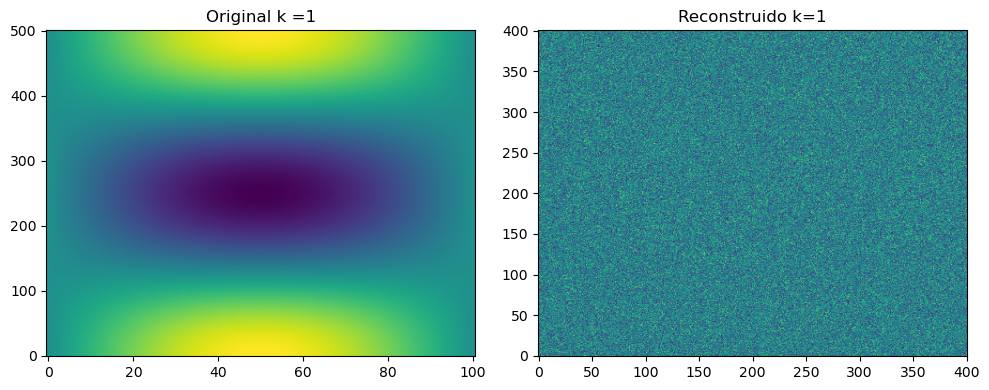

In [18]:
for i in range(1, 2):
    i = str(i)
    pred, true = reconstruct(
        root / f"u_wave_k{i}.pt",
        root / f"flow_models/u_wave_k{i}.fm.pt",
        N=401,
        steps=4000,
    )
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original k ={i}")
    plt.imshow(true.cpu(), origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title("Reconstruido")
    plt.imshow(pred.cpu(), origin="lower", aspect="auto")
    plt.title(f"Reconstruido k={i}")
    plt.tight_layout()
    plt.show()

In [ ]:
# ==============================================================
# 0. IMPORTS, CONSTANTES, UTILIDADES BÁSICAS
# ==============================================================

from pathlib import Path
from abc import ABC, abstractmethod
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # para inspección visual


# -----------------------------------------------------------------
class Sampleable(ABC):
    @property
    @abstractmethod
    def dim(self) -> int: ...
    @abstractmethod
    def sample(self, num_samples: int): ...


# ==============================================================
# 1. DATASET  —  (u⋆ , coords)  +  Sampleable
# ==============================================================


class WaveTensorDataset(Sampleable, torch.utils.data.Dataset):
    """
    u⋆ ∈ ℝ : amplitud exacta
    coords = (x, t_físico)  ∈ ℝ²
    """

    _dim = 3  # u,x,t

    def __init__(self, pt_file: Path, device=DEVICE):
        d = torch.load(pt_file, map_location=device)
        xx, tt = torch.meshgrid(d["x"], d["t"], indexing="ij")
        coords = torch.stack([xx, tt], dim=-1).reshape(-1, 2).float()  # (N,2)
        u_star = d["u"].T.reshape(-1, 1).float()  # (N,1)
        self.u_star, self.coords = u_star.to(device), coords.to(device)

    # Dataset API -------------------------------------------------
    def __len__(self):
        return self.u_star.shape[0]

    def __getitem__(self, idx):
        return self.u_star[idx], self.coords[idx]

    # Sampleable API ---------------------------------------------
    @property
    def dim(self):
        return self._dim

    def sample(self, n):
        idx = torch.randint(0, len(self), (n,), device=self.u_star.device)
        return self.u_star[idx], self.coords[idx]


# ==============================================================
# 2. SCHEDULES  α(t)=t   ,   β(t)=√(1-t)
# ==============================================================


class LinearAlpha:
    def __call__(self, t):
        return t

    def dt(self, t):
        return torch.ones_like(t)


class SquareRootBeta:
    def __call__(self, t):
        return torch.sqrt(1.0 - t)

    def dt(self, t):
        return -0.5 / (torch.sqrt(1.0 - t) + 1e-8)


alpha, beta = LinearAlpha(), SquareRootBeta()

# ==============================================================
# 3. CONDITIONAL PROBABILITY PATH  p_t(u|u⋆)
# ==============================================================


class ConditionalProbabilityPath(ABC, nn.Module):
    def __init__(self, p_data: Sampleable):
        super().__init__()
        self.p_data = p_data

    # ---- Métodos abstractos ------------------------------------
    @abstractmethod
    def sample_conditioning_variable(self, n): ...
    @abstractmethod
    def sample_conditional_path(self, vars, t): ...
    @abstractmethod
    def conditional_vector_field(self, x, vars, t): ...


class WaveConditionalPath(ConditionalProbabilityPath):
    """
    vars = (u⋆ , coords)
    x_t  = α(t) u⋆ + β(t) ε
    """

    def sample_conditioning_variable(self, n):
        return self.p_data.sample(n)  # (u⋆ , coords)

    def sample_conditional_path(self, vars, t):
        u_star, _ = vars
        eps = torch.randn_like(u_star)
        return alpha(t) * u_star + beta(t) * eps  # x_t

    def conditional_vector_field(self, x, vars, t):
        u_star, _ = vars
        A = alpha.dt(t) - (beta.dt(t) / beta(t)) * alpha(t)
        B = beta.dt(t) / beta(t)
        return A * u_star + B * x  # u_t(x|z)


# ==============================================================
# 4.  MODEL θ  — vector field aproximado
# ==============================================================


def mlp(sizes, act=nn.SiLU):
    layers = []
    for i in range(len(sizes) - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if i < len(sizes) - 2:
            layers.append(act())
    return nn.Sequential(*layers)


class MLPVectorField(nn.Module):
    """
    Entrada  = [x_t , x_coord , t_coord , t_ruta]
               1    +     2    +    1    = 4 dim
    Salida   = u_t^θ  (1 dim)
    """

    def __init__(self, hidden=[128, 128, 128]):
        super().__init__()
        self.net = mlp([4] + hidden + [1])

    def forward(self, x_t, coords, t_path):
        return self.net(torch.cat([x_t, coords, t_path], dim=-1))


# ==============================================================
# 5. ENTRENAMIENTO  —  Flow Matching condicional
# ==============================================================


class Trainer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kw): ...
    def train(self, epochs, lr, device):
        self.model.to(device).train()
        opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        pbar = tqdm(range(epochs))
        for ep in pbar:
            opt.zero_grad()
            loss = self.get_train_loss()
            loss.backward()
            opt.step()
            pbar.set_description(f"ep {ep:05d}  loss={loss.item():.3e}")
        self.model.eval()


class ConditionalFMT(Trainer):
    def __init__(self, path: WaveConditionalPath, model: MLPVectorField):
        super().__init__(model)
        self.path = path

    # -----------------------------------------------------------
    def get_train_loss(self, batch_size=BATCH):
        u_star, coords = self.path.sample_conditioning_variable(batch_size)
        t_path = torch.rand(batch_size, 1, device=u_star.device)
        t_path = t_path * (1 - 2 * EPS_T) + EPS_T  # ∈ (ε,1-ε)
        x_t = self.path.sample_conditional_path((u_star, coords), t_path)
        u_ref = self.path.conditional_vector_field(x_t, (u_star, coords), t_path)
        u_pred = self.model(x_t, coords, t_path)
        return F.mse_loss(u_pred, u_ref)


# ==============================================================
# 6. ENTRENAR + GUARDAR
# ==============================================================


def train_flow(pt_file: Path):
    ds = WaveTensorDataset(pt_file)
    path = WaveConditionalPath(ds)
    net = MLPVectorField()
    trainer = ConditionalFMT(path, net)
    trainer.train(STEPS, LR, DEVICE)

    model_dir = pt_file.parent / "flow_models"
    model_dir.mkdir(exist_ok=True)
    model_file = model_dir / pt_file.with_suffix(".fm.pt").name
    torch.save(net.state_dict(), model_file)
    print(f"✅ Modelo guardado en {model_file}")
    return model_file


# ==============================================================
# 7. RECONSTRUCCIÓN  —  Euler
# ==============================================================


class ODE(nn.Module):  # interfaz genérica
    def drift_coefficient(self, u, t): ...


class LearnedODE(ODE):
    def __init__(self, net, coords):
        super().__init__()
        self.net, self.coords = net, coords

    def drift_coefficient(self, u, t):
        return self.net(u, self.coords, t)


class EulerSimulator:
    def __init__(self, ode):
        self.ode = ode

    def step(self, u, t, h):
        return u + self.ode.drift_coefficient(u, t) * h

    @torch.no_grad()
    def simulate(self, u, ts):
        for k in range(ts.shape[1] - 1):
            t = ts[:, k].unsqueeze(-1)
            h = (ts[:, k + 1] - ts[:, k]).unsqueeze(-1)
            u = self.step(u, t, h)
        return u


def reconstruct(pt_file: Path, model_file: Path, N=401, integ_steps=4_000):
    d = torch.load(pt_file, map_location=DEVICE)
    xg = torch.linspace(0, d["x"][-1], N, device=DEVICE)
    tg = torch.linspace(0, d["t"][-1], N, device=DEVICE)
    xx, tt = torch.meshgrid(xg, tg, indexing="ij")
    coords = torch.stack([xx, tt], dim=-1).reshape(-1, 2).float()  # (M,2)
    M = coords.size(0)

    net = MLPVectorField().to(DEVICE)
    net.load_state_dict(torch.load(model_file, map_location=DEVICE))
    ode = LearnedODE(net.eval(), coords)
    solver = EulerSimulator(ode)

    u0 = torch.randn(M, 1, device=DEVICE)  # ε
    ts = torch.linspace(0.0, 1.0, integ_steps + 1, device=DEVICE)
    ts = ts.expand(M, -1)
    u1 = solver.simulate(u0, ts)  # (M,1)

    pred = u1.view(N, N).cpu()
    true = d["u"]  # (N,N)
    return pred, true


# ==============================================================
# 8. EJEMPLO DE USO RÁPIDO  (comentá si no lo querés en libreta)
# ==============================================================

In [28]:
root = Path("wave_solutions")  # ajusta a tu carpeta
k = 4
pt = root / f"u_wave_k{k}.pt"

model = train_flow(pt)

/tmp/ipykernel_3893738/947290862.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt_file, map_location=device)
ep 00062  loss=1.265e+00:   0%|          |

ep 29999  loss=1.661e+00: 100%|██████████| 30000/30000 [01:05<00:00, 460.59it/s]


✅ Modelo guardado en wave_solutions/flow_models/u_wave_k4.fm.pt


/tmp/ipykernel_3893738/947290862.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt_file, map_location=DEVICE)
/tmp/ipykernel_3893738/947290862.py:264: 

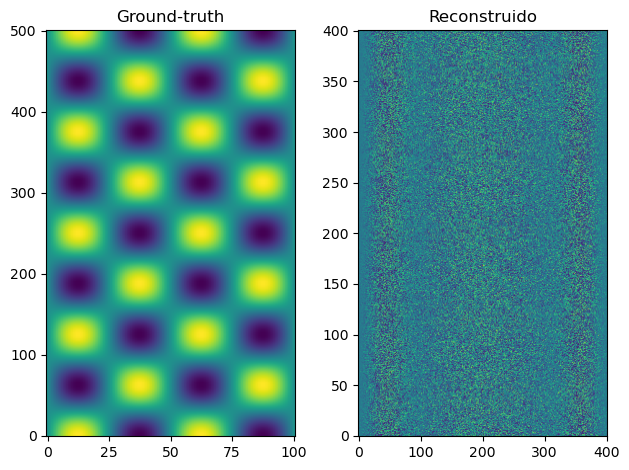

In [29]:
# entrena y guarda modelo
pred, true = reconstruct(pt, model)

plt.subplot(1, 2, 1)
plt.title("Ground-truth")
plt.imshow(true.cpu(), origin="lower", aspect="auto")
plt.subplot(1, 2, 2)
plt.title("Reconstruido")
plt.imshow(pred.T.cpu(), origin="lower", aspect="auto")
plt.tight_layout()
plt.show()